To learn more about Jupyter Notebooks in PyCharm, see [help](https://www.jetbrains.com/help/pycharm/ipython-notebook-support.html).
For an overview of PyCharm, go to Help -> Learn IDE features or refer to [our documentation](https://www.jetbrains.com/help/pycharm/getting-started.html).

# VAWT Unsteady BEM
This exercise deals with a Vertical Axis Wind Turbine, VAWT and how to estimate the time dependent
loads using an unsteady BEM approach, as described in the lecture notes.

$R=3m$, $Vo=8m/s$, $ω=12 rad/s$, $B=2$, $ρ=1.225 kg/m3$, $θp=0$, $S=B∙c/R=0.2$. The airfoil data are given in the
file airfoil.txt.

Q#1: Compute and plot as function of time $pt,B=1$, $px,tot$, $py,tot$, $CT$ and $Cp$. Wait until the solution becomes
periodic and estimate the time averaged $CT$ and $Cp$. $px,tot(t)$ and $py,tot(t)$ are the sum of the loads from all blades at time, t, in x and y direction, respectively and is the load felt by the tower. $pt,B=1(t)$ is the tangential load experienced by only blade #1.

Q#2: Now add one blade so B=3, but keep the solidity at S=0.2. Plot px,tot, py,tot and explain the
difference in the loads experienced by the tower. Compare the time averaged CT and Cp with the 2
bladed VAWT having the same solidity.

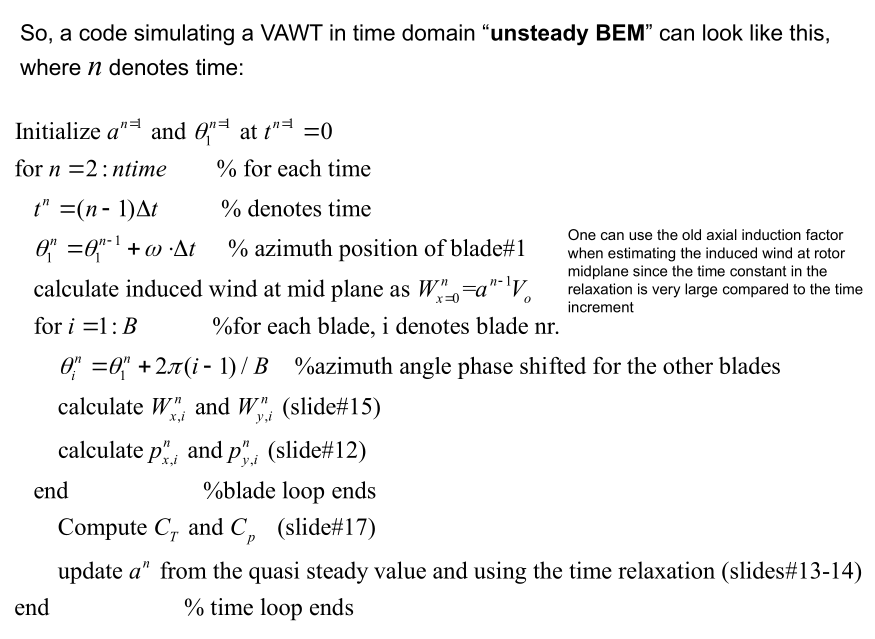

$n$, iteration number

$a$: Induction factor

$\theta_1$: Azimuth position of blade 1

$\omega$: rotational speed

$W_{x=0}^n$: Induced wind speed at mid plane.

$W_{x, i]^n$:

$W_{y=0}^n$: Induced wind speed at mid plane

$B$: number of blades

10 rotations should be enough to reach steady state. I choose 1 degree between every point/iteration.

In [170]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

### Airfoil data
The airfoil data is given, but I have to interpolate between angles to get the lift and drag coefficients

In [171]:
airfoil_data = pd.read_csv("airfoil.txt", sep='\s+', header=None, comment='#')
airfoil_data.columns = ['AoA', 'Cl', 'Cd']
airfoil_data.head()

<>:1: SyntaxWarning: invalid escape sequence '\s'
<>:1: SyntaxWarning: invalid escape sequence '\s'
/tmp/ipykernel_13613/2015589082.py:1: SyntaxWarning: invalid escape sequence '\s'
  airfoil_data = pd.read_csv("airfoil.txt", sep='\s+', header=None, comment='#')


,AoA,Cl,Cd
0,-90.0,0.00,2.00
1,-80.0,-0.35,1.95
2,-70.0,-0.73,1.90
3,-60.0,-1.06,1.70
4,-50.0,-1.27,1.40


In [172]:
# How to interpolate with numpy
np.interp(-75, airfoil_data['AoA'], airfoil_data['Cl'])

np.float64(-0.54)

### Variables and Unsteady BEM Coding

In [173]:
R = 3       # [m]
V0 = 8      # [m/s]
omega = 12  # [rad/s]
B = 2       # [-]
rho = 1.225 # [kg / m³]
theta_p = 0 # [rad]
S = 0.2     # [-], solidity
tau = 2 * R / V0

In [174]:
revolutions = 10

d_theta = np.deg2rad(1) # [rad]
steps_revolution = (2 * np.pi / d_theta)
steps_total = steps_revolution * revolutions # revs. pr. second times steps pr. revolution times revolutions
t_revolution = 2 * np.pi / omega
dt = t_revolution / steps_revolution
ntime = int(steps_total)

print("d_theta", d_theta)
print("steps_total", steps_total)
print("dt", dt)

d_theta 0.017453292519943295
steps_total 3600.0
dt 0.0014544410433286077


In [176]:
a = 0
theta = np.zeros([B, ntime]) # Azimuth position of blades

#theta = np.zeros(B)
Wx = np.zeros([B, ntime])
Wy = np.zeros([B, ntime])
px = np.zeros([B, ntime])
py = np.zeros([B, ntime])
pt = np.zeros([B, ntime])
pn = np.zeros([B, ntime])

CT = np.zeros(ntime)
Cp = np.zeros(ntime)

t = np.zeros(ntime)
a = np.zeros(ntime)


for n in range(1, ntime):
    tn = (n - 1) * dt
    t[n] = tn
    theta[:, n] = theta[:, n - 1] + omega * dt

    # Induced wind speed at mid plane
    for i in range(B):
        theta[i, n] = theta[0, n] + 2 * np.pi / B * i  # accounting for MATLAB notation in slides
        Wx[i, n] = a[i, n] * V0 * (1 - 0.4 * np.sin(theta[i, n]))
        Wy[i, n] = 0.4 * Wx[i, n] * np.cos(theta[i, n])

        # loads(?)
        xi = - R * np.sin(theta[i, n])
        yi = R * np.cos(theta[i, n])
        Vrelxi = omega * yi + V0 - Wx[i]
        Vrelyi = - omega * xi + Wy[i]
        Vnormi = (V0 - Wx[i, n]) * np.sin(theta[i, n]) - Wy[i, n] * np.cos(theta[i, n])
        Vtani = (V0 - Wx[i, n]) * np.cos(theta[i, n]) + Wy[i, n] * np.sin(theta[i, n]) + omega * R
        V2reli = Vnormi**2 + Vtani**2
        phii = np.atan(Vnormi / Vtani)
        alphai = phii - theta_p
        Cl = np.interp(alphai, airfoil_data['AoA'], airfoil_data['Cl'])
        Cd = np.interp(alphai, airfoil_data['AoA'], airfoil_data['Cd'])
        c = S * R / B # c is chord length, derived from solidity
        li = 1/2 * rho * V2reli * c * Cl
        di = 1/2 * rho * V2reli * c * Cd
        pni = li * np.cos(phii) + di * np.sin(phii)
        pt[i, n] = li * np.sin(phii) - di * np.cos(phii)
        px[i, n] = pni * np.sin(theta[i, n]) - pt[i, n] * np.cos(theta[i, n])
        py[i, n] = - pni * np.cos(theta[i, n]) - pt[i, n] * np.sin(theta[i, n])

    CT[i, n] = np.sum(px) / (rho * V0**2 * R)
    Cp[i, n] = omega * np.sum(pt[i, n]) / (rho * V0**3)

    aqs = 0.246 * CT[i, n] + 0.0586 * CT[i, n]**2 + 0.0883 * CT[i, n]**3
    a[i, n] = aqs + (a[i, n - 1] - aqs) * np.exp(-dt / tau)


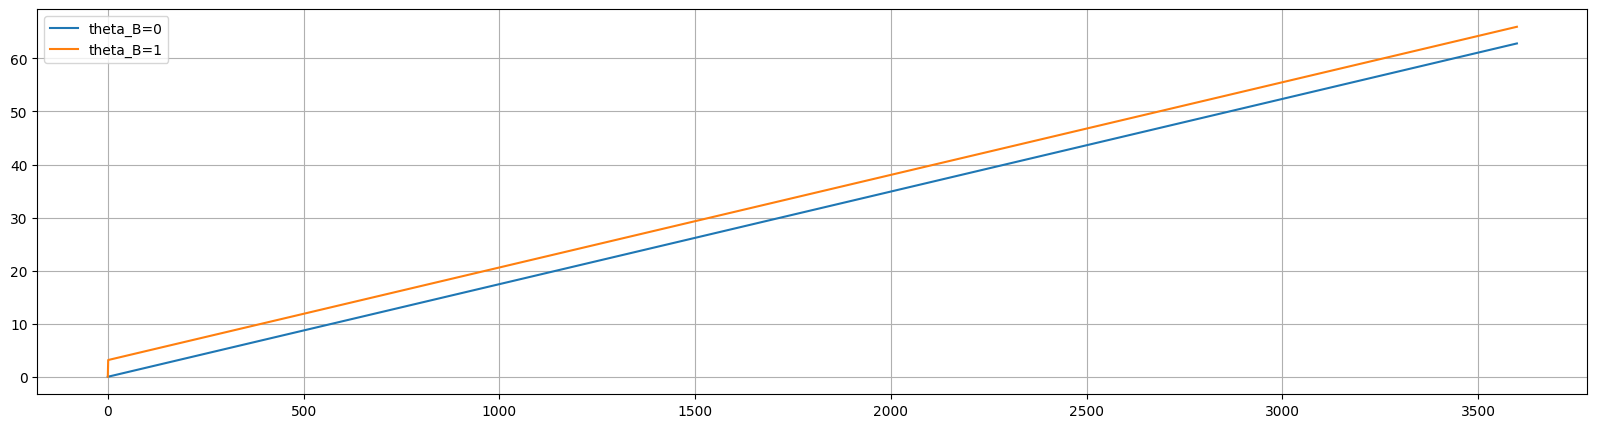

In [177]:
plt.figure(figsize=(20, 5))
plt.plot(theta[0, :])
plt.plot(theta[1, :])
plt.grid(True)
plt.legend(['theta_B=0', 'theta_B=1'])


Text(0.5, 1.0, "['a']")

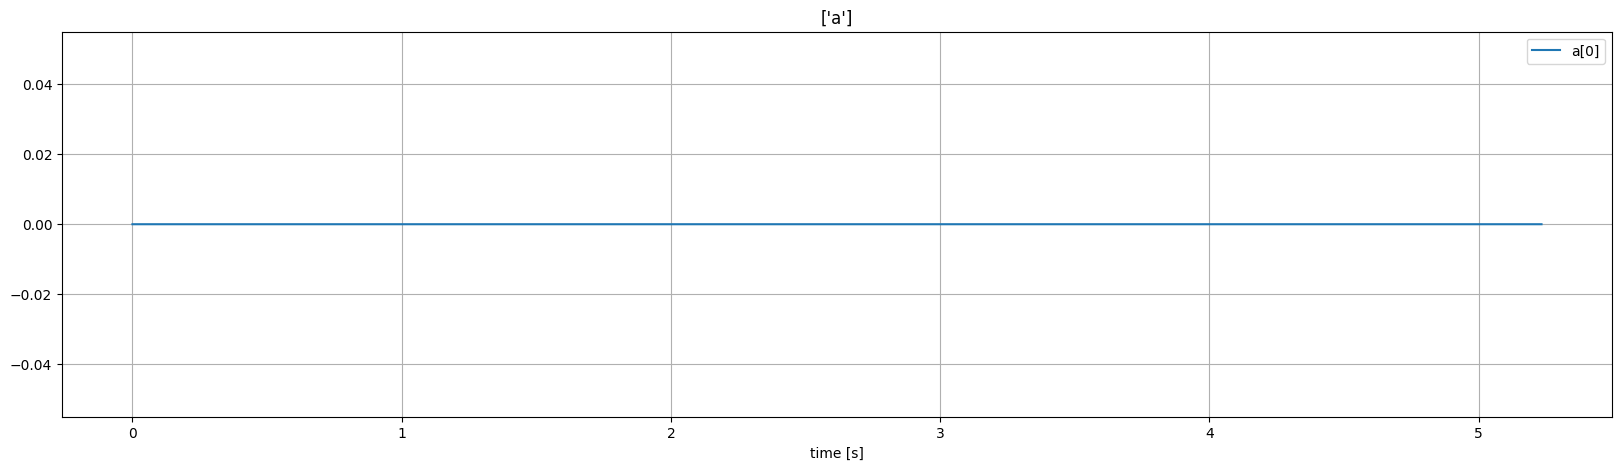

In [182]:
plt.figure(figsize=(20, 5))
plt.plot(t, a[0, :])
plt.grid(True)
plt.xlabel('time [s]')
plt.legend(['a[0]', 'a[1]'])
plt.title(['a'])

ValueError: x and y must have same first dimension, but have shapes (3600,) and (2, 3600)

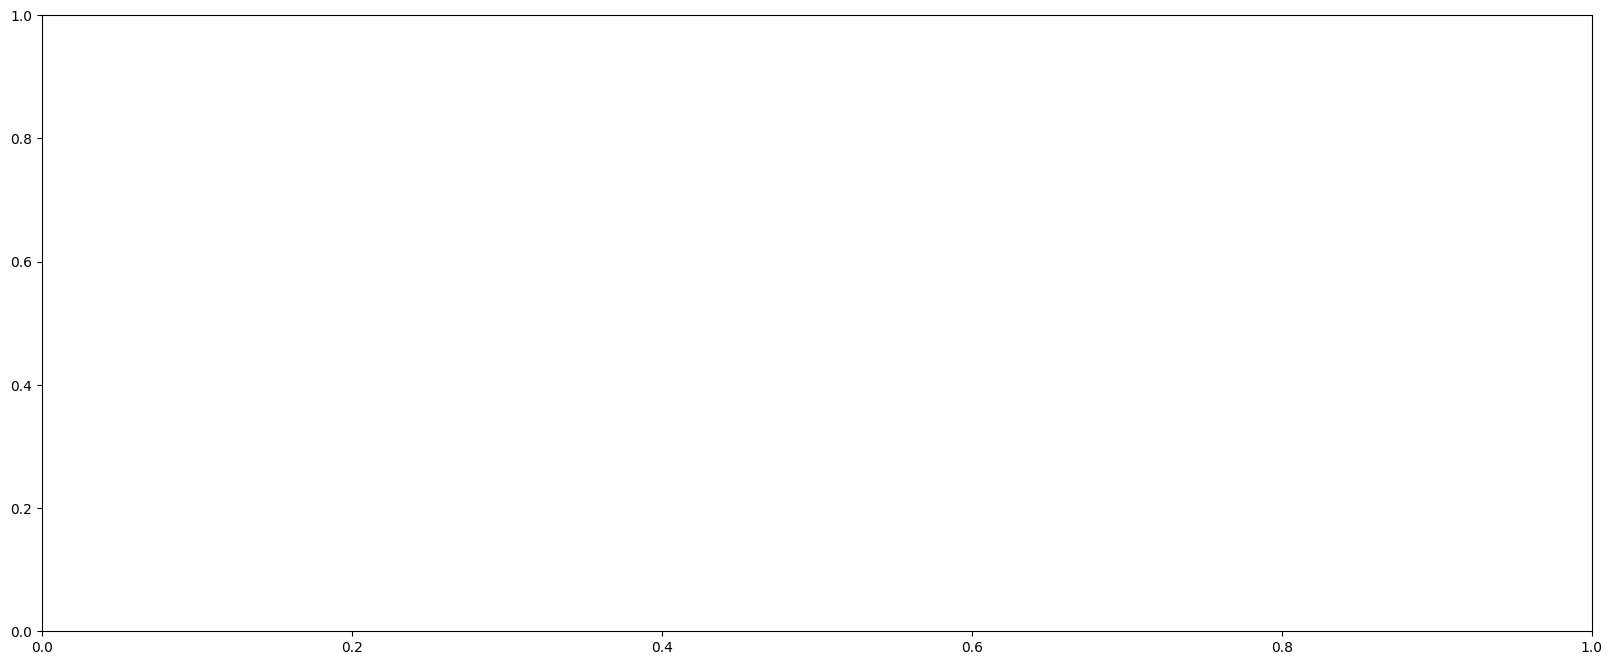

In [155]:
plt.figure(figsize=(20, 8))
plt.plot(t, Cp)
plt.plot(t, CT)
plt.grid(True)
plt.xlabel('time [s]')
plt.legend(['Cp', 'CT'])